In [ ]:
SUBMISSION = 328

from google.colab import drive
drive.mount('/content/drive')

!pip install catboost -q

# Standard libraries
import os
import glob
import time
import multiprocessing
from concurrent.futures import ProcessPoolExecutor, as_completed
import pickle

# Data handling and manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Machine learning and preprocessing
import sklearn
from sklearn.utils.validation import _check_n_features
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.inspection import permutation_importance

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Model saving/loading
import joblib

# Get the number of CPU threads available
num_threads = multiprocessing.cpu_count()
print(f"Number of CPU threads available: {num_threads}")

# Filepaths
TRAIN_X = '/content/drive/MyDrive/building_classification/X_train_processed.csv'
TEST_X = '/content/drive/MyDrive/building_classification/X_test_processed.csv'
TRAIN_Y_PATH = '/content/drive/MyDrive/building_classification/Y_train_processed.csv'

SAMPLE_SUBMISSION_PATH = '/content/drive/MyDrive/building_classification/sample_submission_v0.1.0.csv.gz'
OUTPUT_SUBMISSION_PATH = '/content/drive/MyDrive/building_classification/submission_sub328.csv'

X_test = pd.read_csv(TEST_X)
X_train = pd.read_csv(TRAIN_X)
Y_train = pd.read_csv(TRAIN_Y_PATH)

# Directory to save models
model_save_path = "/content/drive/MyDrive/building_classification/models_sub328/"
# If path exist delete existing folder
if os.path.exists(model_save_path):
    os.system(f"rm -r {model_save_path}")
os.makedirs(model_save_path, exist_ok=True)

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 25.1 MB/s eta 0:00:00
Number of CPU threads available: 8


In [ ]:
# display full columns
pd.set_option('display.max_columns', None)
X_train.head()

,ABS_p05_value,ABS_95th_percentile_of_0_1_changes,RATIO_mode_DIV_total_len,RATIO_percentile_95_DIV_percentile_05,RATIO_num_of_unique_DIV_mean,RATIO_unique_DIV_sd,RATIO_sum_reoccur_DIV_unique,RATIO_first_min_to_last_min_DIV_len,RATIO_longest_one_run_ratio,peak_height_min,peak_width_median,peak_width_min,missing_values_ratio,missing_runs_ratio,fraction_of_values_that_are_zero,mean_interval_between_0s,abs_energy_DIV_len,benford_corr,change_quantiles_mean,permutation_entropy_3,seasonal_mean_DIV_seasonal_std,rolling_max_2,rolling_max_144,fft_phase_mean,wavelet_min_haar_1,wavelet_max_haar_2,wavelet_min_haar_2,autocorr_lag_1,autocorr_lag_36,is_Air_Flow_Setpoint,is_Cooling_Supply_Air_Temp_deadband_Setpoint,is_Cooling_Temperature_Setpoint,is_differential_pressure_Setpoint,is_Discharge_Air_Temperature_Setpoint,is_Flow_Setpoint,is_Heating_Demand_Setpoint,is_Heating_Supply_Air_Temperature_Deadband_Setpoint,is_Heating_Temperature_Setpoint,is_Humidity_Setpoint,is_Low_Outside_Air_Temperature_Enable_Setpoint,is_Max_Air_Temperature_Setpoint,is_Min_Air_Temperature_Setpoint,is_Outside_Air_Lockout_Temperature_Setpoint,is_Outside_Air_Temperature_Setpoint,is_Room_Air_Temperature_Setpoint,is_Speed_Setpoint,is_Static_Pressure_Setpoint,is_Temperature_Setpoint,is_Time_Setpoint,is_Water_Temperature_Setpoint,is_Zone_Air_Humidity_Setpoint,RATIO_peak_height_median_DIV_peak_width_median
0,30.00,0.0,0.999750,1.000000,0.066683,4.218478,6.003000e+04,0.000000,0.0,0.00,0.000000,0.000000,0.011991,0.000250,0.000250,0.00000,8.997752e+02,0.062915,0.000000,0.006144,6.122196e-04,30.00,30.00,-5.224122e-16,3.932840e-16,21.213203,6.661338e-16,-0.000250,-0.000252,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0.000000
1,22.50,0.0,0.999875,1.000000,0.088900,7.964365,9.029250e+04,0.000000,0.0,0.00,0.000000,0.000000,0.009717,0.000623,0.000125,0.00000,5.061869e+02,0.295657,0.000000,0.003324,-1.017610e-04,22.50,22.50,5.809065e-16,1.183141e-15,15.909903,4.996004e-16,-0.000125,-0.000125,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0.000000
2,1.76,0.0,0.081988,171.781818,18.981519,18.998546,2.120484e+02,0.269565,0.0,100.24,1.529241,0.500536,0.003727,0.001242,0.000000,0.00000,1.747332e+04,0.924611,5.491232,1.682359,-2.150867e-17,488.96,488.96,-1.941856e-17,6.567036e-17,258.291965,3.247939e-17,0.970319,0.272470,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,116.685368
3,3834.00,0.0,0.999379,1.000000,0.000522,0.020947,1.543568e+07,0.134666,0.0,0.00,0.000000,0.000000,0.002110,0.000869,0.000621,163129.75225,1.469043e+07,0.062915,0.000000,0.009422,-3.374471e-17,3834.00,3834.00,5.432473e-16,2.223495e-13,2711.047399,1.081357e-13,-0.000621,-0.000624,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000
4,234.00,0.0,0.999379,1.000000,0.008552,0.343054,9.412650e+05,0.773665,0.0,0.00,0.000000,0.000000,0.001118,0.000497,0.000621,935935.79025,5.472199e+04,0.295657,0.000000,0.009945,-2.539742e-18,234.00,234.00,3.902600e-04,1.181703e-14,165.462987,0.000000e+00,0.199503,-0.000624,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.000000


In [ ]:
# Number of features used
print("Number of features used: " ,len(X_train.columns))

Number of features used:  52


# Training Function

for now only using the best model per label.

In [ ]:
best_model_dict = {
    "Active_Power_Sensor": "cat",
    "Air_Flow_Sensor": "cat",
    "Air_Flow_Setpoint": "cat",
    "Air_Temperature_Sensor": "cat",
    "Air_Temperature_Setpoint": "cat",
    "Alarm": "cat",
    "Angle_Sensor": "cat",
    "Average_Zone_Air_Temperature_Sensor": "cat",
    "Chilled_Water_Differential_Temperature_Sensor": "cat",
    "Chilled_Water_Return_Temperature_Sensor": "cat",
    "Chilled_Water_Supply_Flow_Sensor": "cat",
    "Chilled_Water_Supply_Temperature_Sensor": "cat",
    "Command": "cat",
    'Cooling_Demand_Sensor': "cat",
    "Cooling_Demand_Setpoint": "cat",
    "Cooling_Supply_Air_Temperature_Deadband_Setpoint": "cat",
    "Cooling_Temperature_Setpoint": "cat",
    "Current_Sensor": "cat",
    "Damper_Position_Sensor": "cat",
    "Damper_Position_Setpoint": "cat",
    "Demand_Sensor": "cat",
    "Dew_Point_Setpoint": "cat",
    "Differential_Pressure_Sensor": "cat",
    "Differential_Pressure_Setpoint": "cat",
    "Differential_Supply_Return_Water_Temperature_Sensor": "cat",
    "Discharge_Air_Dewpoint_Sensor": "cat",
    "Discharge_Air_Temperature_Sensor": "cat",
    "Discharge_Air_Temperature_Setpoint": "cat",
    "Discharge_Water_Temperature_Sensor": "cat",
    "Duration_Sensor": "cat",
    "Electrical_Power_Sensor": "cat",
    "Energy_Usage_Sensor": "cat",
    "Filter_Differential_Pressure_Sensor": "cat",
    "Flow_Sensor": "cat",
    "Flow_Setpoint": "cat",
    "Frequency_Sensor": "cat",
    'Heating_Demand_Sensor': "cat",
    "Heating_Demand_Setpoint": "cat",
    "Heating_Supply_Air_Temperature_Deadband_Setpoint": "cat",
    "Heating_Temperature_Setpoint": "cat",
    "Hot_Water_Flow_Sensor": "cat",
    "Hot_Water_Return_Temperature_Sensor": "cat",
    "Hot_Water_Supply_Temperature_Sensor": "cat",
    "Humidity_Setpoint": "cat",
    "Load_Current_Sensor": "cat",
    "Low_Outside_Air_Temperature_Enable_Setpoint": "cat",
    "Max_Air_Temperature_Setpoint": "cat",
    "Min_Air_Temperature_Setpoint": "cat",
    "Outside_Air_CO2_Sensor": "cat",
    "Outside_Air_Enthalpy_Sensor": "cat",
    "Outside_Air_Humidity_Sensor": "cat",
    "Outside_Air_Lockout_Temperature_Setpoint": "cat",
    "Outside_Air_Temperature_Sensor": "cat",
    "Outside_Air_Temperature_Setpoint": "cat",
    "Parameter": "cat",
    "Peak_Power_Demand_Sensor": "cat",
    "Position_Sensor": "cat",
    "Power_Sensor": "cat",
    "Pressure_Sensor": "cat",
    "Rain_Sensor": "cat",
    "Reactive_Power_Sensor": "cat",
    "Reset_Setpoint": "cat",
    "Return_Air_Temperature_Sensor": "cat",
    "Return_Water_Temperature_Sensor": "cat",
    "Room_Air_Temperature_Setpoint": "cat",
    "Sensor": "cat",
    "Setpoint": "cat",
    "Solar_Radiance_Sensor": "cat",
    "Speed_Setpoint": "cat",
    "Static_Pressure_Sensor": "cat",
    "Static_Pressure_Setpoint": "cat",
    "Status": "cat",
    "Supply_Air_Humidity_Sensor": "cat",
    "Supply_Air_Static_Pressure_Sensor": "cat",
    "Supply_Air_Static_Pressure_Setpoint": "cat",
    "Supply_Air_Temperature_Sensor": "cat",
    "Supply_Air_Temperature_Setpoint": "cat",
    "Temperature_Sensor": "cat",
    "Temperature_Setpoint": "cat",
    "Thermal_Power_Sensor": "cat",
    "Time_Setpoint": "cat",
    "Usage_Sensor": "cat",
    "Valve_Position_Sensor": "cat",
    "Voltage_Sensor": "cat",
    "Warmest_Zone_Air_Temperature_Sensor": "cat",
    "Water_Flow_Sensor": "cat",
    "Water_Temperature_Sensor": "cat",
    "Water_Temperature_Setpoint": "cat",
    "Wind_Direction_Sensor": "cat",
    "Wind_Speed_Sensor": "cat",
    "Zone_Air_Dewpoint_Sensor": "cat",
    "Zone_Air_Humidity_Sensor": "cat",
    "Zone_Air_Humidity_Setpoint": "cat",
    "Zone_Air_Temperature_Sensor": "cat",
}

In [ ]:
# Tuned scaling factors for each label (from your separate tuning script)
tuned_scaling_factors = {
    "Active_Power_Sensor": 0.0,
    "Air_Flow_Sensor": 0.0,
    "Air_Flow_Setpoint": 0.25,
    "Air_Temperature_Sensor": 0.0,
    "Air_Temperature_Setpoint": 0.0,
    "Alarm": 0.75,
    "Angle_Sensor": 0.0,
    "Average_Zone_Air_Temperature_Sensor": 0.0,
    "Chilled_Water_Differential_Temperature_Sensor": 0.25,
    "Chilled_Water_Return_Temperature_Sensor": 0.5,
    "Command": 0.7,
    "Cooling_Demand_Sensor": 0.1,  # Handle these separately if needed
    "Chilled_Water_Supply_Flow_Sensor": 0.1,
    "Chilled_Water_Supply_Temperature_Sensor": 0.7,
    "Cooling_Demand_Setpoint": 0.1,
    "Cooling_Supply_Air_Temperature_Deadband_Setpoint": 0.1,
    "Cooling_Temperature_Setpoint": 0.3,
    "Current_Sensor": 0.1,
    "Damper_Position_Sensor": 0.0,
    "Damper_Position_Setpoint": 0.3,
    "Demand_Sensor": 0.2,
    "Dew_Point_Setpoint": 0.1,
    "Differential_Pressure_Sensor": 0.1,
    "Differential_Pressure_Setpoint": 0.0,
    "Differential_Supply_Return_Water_Temperature_Sensor": 0.0,
    "Discharge_Air_Dewpoint_Sensor": 0.2,
    "Discharge_Air_Temperature_Sensor": 0.1,
    "Discharge_Air_Temperature_Setpoint": 0.0,
    "Discharge_Water_Temperature_Sensor": 0.1,
    "Duration_Sensor": 0.0,
    "Electrical_Power_Sensor": 0.2,
    "Energy_Usage_Sensor": 0.0,
    "Filter_Differential_Pressure_Sensor": 0.1,
    "Flow_Sensor": 0.1,
    "Flow_Setpoint": 0.1,
    "Frequency_Sensor": 0.0,
    "Heating_Demand_Sensor": 0.1,
    "Heating_Demand_Setpoint": 0.0,
    "Heating_Supply_Air_Temperature_Deadband_Setpoint": 0.0,
    "Heating_Temperature_Setpoint": 0.7,
    "Hot_Water_Flow_Sensor": 0.1,
    "Hot_Water_Return_Temperature_Sensor": 0.7,
    "Hot_Water_Supply_Temperature_Sensor": 0.7,
    "Humidity_Setpoint": 1.1,
    "Load_Current_Sensor": 0.8,
    "Low_Outside_Air_Temperature_Enable_Setpoint": 0.0,
    "Max_Air_Temperature_Setpoint": 0.0,
    "Min_Air_Temperature_Setpoint": 0.2,
    "Outside_Air_CO2_Sensor": 0.0,
    "Outside_Air_Enthalpy_Sensor": 0.1,
    "Outside_Air_Humidity_Sensor": 0.2,
    "Outside_Air_Lockout_Temperature_Setpoint": 0.0,
    "Outside_Air_Temperature_Sensor": 0.1,
    "Outside_Air_Temperature_Setpoint": 0.0,
    "Parameter": 0.1,
    "Peak_Power_Demand_Sensor": 0.2,
    "Position_Sensor": 0.1,
    "Power_Sensor": 0.2,
    "Pressure_Sensor": 0.1,
    "Rain_Sensor": 0.3,
    "Reactive_Power_Sensor": 0.0,
    "Reset_Setpoint": 0.1,
    "Return_Air_Temperature_Sensor": 0.1,
    "Return_Water_Temperature_Sensor": 0.1,
    "Room_Air_Temperature_Setpoint": 0.1,
    "Sensor": 0.0,
    "Setpoint": 0.3,
    "Solar_Radiance_Sensor": 0.2,
    "Speed_Setpoint": 0.1,
    "Static_Pressure_Sensor": 0.0,
    "Static_Pressure_Setpoint": 0.1,
    "Status": 0.3,
    "Supply_Air_Humidity_Sensor": 0.1,
    "Supply_Air_Static_Pressure_Sensor": 0.0,
    "Supply_Air_Static_Pressure_Setpoint": 0.1,
    "Supply_Air_Temperature_Sensor": 0.1,
    "Supply_Air_Temperature_Setpoint": 0.1,
    "Temperature_Sensor": 0.0,
    "Temperature_Setpoint": 0.3,
    "Thermal_Power_Sensor": 0.0,
    "Time_Setpoint": 0.0,
    "Usage_Sensor": 0.1,
    "Valve_Position_Sensor": 0.1,
    "Voltage_Sensor": 0.0,
    "Warmest_Zone_Air_Temperature_Sensor": 0.1,
    "Water_Flow_Sensor": 0.0,
    "Water_Temperature_Sensor": 0.1,
    "Water_Temperature_Setpoint": 0.2,
    "Wind_Direction_Sensor": 0.1,
    "Wind_Speed_Sensor": 0.1,
    "Zone_Air_Dewpoint_Sensor": 0.0,
    "Zone_Air_Humidity_Sensor": 0.1,
    "Zone_Air_Humidity_Setpoint": 0.3,
    "Zone_Air_Temperature_Sensor": 0.0,
}

In [ ]:
# 50 seeds
seeds = [8, 88, 888, 1, 175, 907, 354, 917, 182, 695, 744, 665, 981, 876, 286, 241, 159, 219, 868, 277,
         521, 278, 755, 387, 113, 115, 576, 527, 270, 663, 495, 214, 620, 376, 912, 50, 733, 168, 101, 689,
         947, 382, 649, 456, 544, 993, 127, 730, 760, 855]



# ====================================================
#                 Evaluation Function
# ====================================================

def evaluate_models(y_true, y_pred):
    """Compute F1, Precision, and Recall for given predictions."""
    return {
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0)
    }

# ====================================================
#              Model Parameter Factory
# ====================================================

def get_model_params(model_type, seed, pos_weight, class_weights):
    """
    Return an instantiated model given the model_type.
    Extend this function if you want to add or modify models.
    """
    model_map = {
        'cat': CatBoostClassifier(
            iterations=100,
            random_state=seed,
            verbose=False,
            thread_count=1,
            class_weights=class_weights,
            eval_metric='AUC',
        ),
    }

    if model_type not in model_map:
        raise ValueError(f"Model type {model_type} is not supported.")

    return model_map[model_type]


# ====================================================
#               Training Function
# ====================================================

def train_models_for_label(label,
                           X_train,
                           Y_train,
                           model_save_path,
                           best_model_dict,
                           seed,
                           n_splits=3):
    """
    Train and cross-validate a model for the specified label.
    Then retrain on the full dataset and save the model.

    Returns:
        (label, seed, final_metrics, model)
        or
        (label, seed, None, None) if an error occurs
    """
    try:
        # ------------------------------------------------
        # Prepare the data
        # ------------------------------------------------
        y = Y_train[label]
        mask = y != 0
        # Convert -1 to 0, and keep 1 as 1
        y_binary = y[mask].replace({-1: 0, 1: 1})
        X_sub = X_train.loc[mask]
        y_sub = y_binary

        # Get the specific model type for this label
        model_type = best_model_dict.get(label)
        if not model_type:
            print(f"No model type specified for label '{label}'")
            return (label, seed, None, None, None)


        # ------------------------------------------------
        # Calculate class weights or pos_weight
        # ------------------------------------------------

        # Look up the tuned scaling factor for this label (default to 0.1 if not found)
        scaling_factor = tuned_scaling_factors.get(label, 0.1)
        if scaling_factor is None:
            # Decide on a fallback strategy if None is returned.
            print(f"Warning: No tuned scaling factor for {label}. Using default of 0.1")
            scaling_factor = 0.1

        # Compute the ratio and then the pos_weight using the tuned scaling factor
        ratio = sum(y_sub == 0) / sum(y_sub == 1)
        pos_weight = max(1.0, ratio * scaling_factor)
        class_weights = [1, pos_weight]

        # ------------------------------------------------
        # Instantiate the model
        # ------------------------------------------------
        model = get_model_params(model_type, seed, pos_weight, class_weights)

        # ------------------------------------------------
        # Train on the entire dataset
        # ------------------------------------------------
        model.fit(X_sub, y_sub)

        # ------------------------------------------------
        # Save the final model
        # ------------------------------------------------
        model_filename = f"{label}_{model_type}_seed{seed}_model.joblib"
        model_path = os.path.join(model_save_path, model_filename)
        joblib.dump(model, model_path)

        final_metrics = None
        confusion_matrices = None

        return (label, seed, final_metrics, model, confusion_matrices)

    except Exception as e:
        print(f"Error processing label '{label}' with seed {seed}: {e}")
        return (label, seed, None, None, None)

# Run Training

In [ ]:
from collections import defaultdict
from itertools import product

# ------------------------------------------------
# Prepare tasks
# ------------------------------------------------

label_cols = Y_train.columns.tolist()

valid_labels = [label for label in label_cols if label in best_model_dict]
tasks = list(product(valid_labels, seeds))

# Create the tuple that train_models_for_label expects
tasks = [
    (label, X_train, Y_train, model_save_path, best_model_dict, seed)
    for (label, seed) in tasks
]

# Dictionary to store results for each label and seed
models = defaultdict(dict)

# Dictionary to store aggregated confusion matrices per label.
aggregated_conf_matrices = defaultdict(lambda: None)

# ------------------------------------------------
# Parallel training
# ------------------------------------------------
with ProcessPoolExecutor(max_workers=8) as executor:
    futures = {executor.submit(train_models_for_label, *task): task for task in tasks}

    for future in tqdm(as_completed(futures), total=len(futures), desc="Training Labels and Seeds"):
        task = futures[future]
        label, seed = task[0], task[5]
        try:
            result_label, result_seed, metrics, model, conf_matrices = future.result()
            if result_label not in models:
                models[result_label] = {}
            models[result_label][result_seed] = {
                'metrics': metrics,
                'model': model,
                'confusion_matrices': conf_matrices
            }

            # Now aggregate the confusion matrices.
            # First, sum the confusion matrices from all folds of this seed.
            if conf_matrices is not None:
                seed_cm = np.sum(conf_matrices, axis=0)

                # If we already have an aggregated confusion matrix for this label, add to it.
                if aggregated_conf_matrices[result_label] is None:
                    aggregated_conf_matrices[result_label] = seed_cm
                else:
                    aggregated_conf_matrices[result_label] += seed_cm

        except Exception as exc:
            print(f"Label '{label}' with seed {seed} generated an exception: {exc}")
            models[label][seed] = None

Training Labels and Seeds:  14%|█▎        | 643/4700 [03:45<20:43,  3.26it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 8: division by zero


Training Labels and Seeds:  14%|█▎        | 644/4700 [03:45<17:08,  3.94it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 88: division by zero


Training Labels and Seeds:  14%|█▎        | 645/4700 [03:45<14:18,  4.73it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 888: division by zero


Training Labels and Seeds:  14%|█▍        | 647/4700 [03:45<09:30,  7.11it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 1: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 175: division by zero


Training Labels and Seeds:  14%|█▍        | 649/4700 [03:45<08:39,  7.80it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 907: division by zero


Training Labels and Seeds:  14%|█▍        | 650/4700 [03:45<08:33,  7.89it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 354: division by zero

Training Labels and Seeds:  14%|█▍        | 652/4700 [03:45<06:34, 10.26it/s]


Error processing label 'Cooling_Demand_Sensor' with seed 917: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 182: division by zero


Training Labels and Seeds:  14%|█▍        | 654/4700 [03:46<06:31, 10.34it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 695: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 744: division by zero


Training Labels and Seeds:  14%|█▍        | 656/4700 [03:46<06:35, 10.22it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 665: division by zero


Training Labels and Seeds:  14%|█▍        | 658/4700 [03:46<05:43, 11.75it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 981: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 876: division by zero


Training Labels and Seeds:  14%|█▍        | 660/4700 [03:46<06:04, 11.08it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 286: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 241: division by zero


Training Labels and Seeds:  14%|█▍        | 663/4700 [03:46<05:25, 12.40it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 159: division by zero


Training Labels and Seeds:  14%|█▍        | 665/4700 [03:46<05:06, 13.16it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 219: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 868: division by zero


Training Labels and Seeds:  14%|█▍        | 668/4700 [03:47<04:32, 14.82it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 277: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 521: division by zero


Training Labels and Seeds:  14%|█▍        | 670/4700 [03:47<04:52, 13.78it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 278: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 755: division by zero


Training Labels and Seeds:  14%|█▍        | 672/4700 [03:47<05:13, 12.85it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 387: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 113: division by zero


Training Labels and Seeds:  14%|█▍        | 675/4700 [03:47<04:50, 13.85it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 115: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 576: division by zero


Training Labels and Seeds:  14%|█▍        | 677/4700 [03:47<05:15, 12.75it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 527: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 270: division by zero


Training Labels and Seeds:  14%|█▍        | 679/4700 [03:47<05:11, 12.92it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 663: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 495: division by zero


Training Labels and Seeds:  14%|█▍        | 681/4700 [03:48<05:17, 12.64it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 214: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 620: division by zero


Training Labels and Seeds:  15%|█▍        | 683/4700 [03:48<05:19, 12.58it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 376: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 912: division by zero


Training Labels and Seeds:  15%|█▍        | 685/4700 [03:48<05:25, 12.35it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 50: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 733: division by zero


Training Labels and Seeds:  15%|█▍        | 687/4700 [03:48<05:28, 12.23it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 168: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 101: division by zero


Training Labels and Seeds:  15%|█▍        | 689/4700 [03:48<05:23, 12.39it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 689: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 947: division by zero


Training Labels and Seeds:  15%|█▍        | 691/4700 [03:48<05:17, 12.65it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 382: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 649: division by zero


Training Labels and Seeds:  15%|█▍        | 693/4700 [03:49<05:09, 12.95it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 456: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 544: division by zero


Training Labels and Seeds:  15%|█▍        | 695/4700 [03:49<05:07, 13.03it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 993: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 127: division by zero


Training Labels and Seeds:  15%|█▍        | 697/4700 [03:49<05:11, 12.84it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 730: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 760: division by zero


Training Labels and Seeds:  15%|█▍        | 699/4700 [03:49<05:13, 12.75it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 855: division by zero


Training Labels and Seeds:  38%|███▊      | 1793/4700 [10:04<16:28,  2.94it/s]

Error processing label 'Heating_Demand_Sensor' with seed 8: division by zero


Training Labels and Seeds:  38%|███▊      | 1794/4700 [10:04<13:33,  3.57it/s]

Error processing label 'Heating_Demand_Sensor' with seed 88: division by zero


Training Labels and Seeds:  38%|███▊      | 1795/4700 [10:05<11:18,  4.28it/s]

Error processing label 'Heating_Demand_Sensor' with seed 888: division by zero


Training Labels and Seeds:  38%|███▊      | 1797/4700 [10:05<07:26,  6.50it/s]

Error processing label 'Heating_Demand_Sensor' with seed 1: division by zero


Training Labels and Seeds:  38%|███▊      | 1799/4700 [10:05<05:36,  8.62it/s]

Error processing label 'Heating_Demand_Sensor' with seed 175: division by zero


Training Labels and Seeds:  38%|███▊      | 1801/4700 [10:05<04:41, 10.30it/s]

Error processing label 'Heating_Demand_Sensor' with seed 907: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 354: division by zero


Training Labels and Seeds:  38%|███▊      | 1803/4700 [10:05<04:47, 10.08it/s]

Error processing label 'Heating_Demand_Sensor' with seed 917: division by zero


Training Labels and Seeds:  38%|███▊      | 1805/4700 [10:05<04:07, 11.69it/s]

Error processing label 'Heating_Demand_Sensor' with seed 182: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 695: division by zero


Training Labels and Seeds:  38%|███▊      | 1807/4700 [10:05<04:11, 11.53it/s]

Error processing label 'Heating_Demand_Sensor' with seed 744: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 665: division by zero


Training Labels and Seeds:  38%|███▊      | 1809/4700 [10:06<04:22, 11.03it/s]

Error processing label 'Heating_Demand_Sensor' with seed 981: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 876: division by zero


Training Labels and Seeds:  39%|███▊      | 1812/4700 [10:06<03:46, 12.74it/s]

Error processing label 'Heating_Demand_Sensor' with seed 286: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 241: division by zero


Training Labels and Seeds:  39%|███▊      | 1814/4700 [10:06<03:56, 12.20it/s]

Error processing label 'Heating_Demand_Sensor' with seed 159: division by zero


Training Labels and Seeds:  39%|███▊      | 1816/4700 [10:06<03:30, 13.68it/s]

Error processing label 'Heating_Demand_Sensor' with seed 219: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 868: division by zero


Training Labels and Seeds:  39%|███▊      | 1818/4700 [10:06<03:37, 13.27it/s]

Error processing label 'Heating_Demand_Sensor' with seed 277: division by zero


Training Labels and Seeds:  39%|███▊      | 1820/4700 [10:06<03:26, 13.96it/s]

Error processing label 'Heating_Demand_Sensor' with seed 521: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 278: division by zero


Training Labels and Seeds:  39%|███▉      | 1822/4700 [10:06<03:12, 14.92it/s]

Error processing label 'Heating_Demand_Sensor' with seed 755: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 387: division by zero


Training Labels and Seeds:  39%|███▉      | 1824/4700 [10:07<03:22, 14.22it/s]

Error processing label 'Heating_Demand_Sensor' with seed 113: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 115: division by zero


Training Labels and Seeds:  39%|███▉      | 1826/4700 [10:07<03:35, 13.33it/s]

Error processing label 'Heating_Demand_Sensor' with seed 576: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 527: division by zero


Training Labels and Seeds:  39%|███▉      | 1828/4700 [10:07<03:53, 12.28it/s]

Error processing label 'Heating_Demand_Sensor' with seed 270: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 663: division by zero


Training Labels and Seeds:  39%|███▉      | 1830/4700 [10:07<03:59, 12.00it/s]

Error processing label 'Heating_Demand_Sensor' with seed 495: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 214: division by zero


Training Labels and Seeds:  39%|███▉      | 1832/4700 [10:07<04:00, 11.92it/s]

Error processing label 'Heating_Demand_Sensor' with seed 620: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 376: division by zero


Training Labels and Seeds:  39%|███▉      | 1834/4700 [10:08<03:59, 11.99it/s]

Error processing label 'Heating_Demand_Sensor' with seed 912: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 50: division by zero


Training Labels and Seeds:  39%|███▉      | 1836/4700 [10:08<04:02, 11.83it/s]

Error processing label 'Heating_Demand_Sensor' with seed 733: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 168: division by zero


Training Labels and Seeds:  39%|███▉      | 1838/4700 [10:08<03:57, 12.08it/s]

Error processing label 'Heating_Demand_Sensor' with seed 101: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 689: division by zero


Training Labels and Seeds:  39%|███▉      | 1840/4700 [10:08<03:59, 11.96it/s]

Error processing label 'Heating_Demand_Sensor' with seed 947: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 382: division by zero


Training Labels and Seeds:  39%|███▉      | 1842/4700 [10:08<03:57, 12.03it/s]

Error processing label 'Heating_Demand_Sensor' with seed 649: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 456: division by zero


Training Labels and Seeds:  39%|███▉      | 1844/4700 [10:08<03:56, 12.07it/s]

Error processing label 'Heating_Demand_Sensor' with seed 544: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 993: division by zero


Training Labels and Seeds:  39%|███▉      | 1846/4700 [10:09<03:56, 12.07it/s]

Error processing label 'Heating_Demand_Sensor' with seed 127: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 730: division by zero


Training Labels and Seeds:  39%|███▉      | 1848/4700 [10:09<03:51, 12.32it/s]

Error processing label 'Heating_Demand_Sensor' with seed 760: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 855: division by zero


Training Labels and Seeds: 100%|██████████| 4700/4700 [26:07<00:00,  3.00it/s]


# generate predictions

In [ ]:
X_test_clean = X_test.copy()

In [ ]:
# Align the column order to match the training set
X_test_clean = X_test_clean[X_train.columns] # Note that filename column will be dropped here too

In [ ]:
sample_submission = pd.read_csv(SAMPLE_SUBMISSION_PATH, compression='gzip')
sample_submission.head()

,filename,Active_Power_Sensor,Air_Flow_Sensor,Air_Flow_Setpoint,Air_Temperature_Sensor,Air_Temperature_Setpoint,Alarm,Angle_Sensor,Average_Zone_Air_Temperature_Sensor,Chilled_Water_Differential_Temperature_Sensor,Chilled_Water_Return_Temperature_Sensor,Chilled_Water_Supply_Flow_Sensor,Chilled_Water_Supply_Temperature_Sensor,Command,Cooling_Demand_Sensor,Cooling_Demand_Setpoint,Cooling_Supply_Air_Temperature_Deadband_Setpoint,Cooling_Temperature_Setpoint,Current_Sensor,Damper_Position_Sensor,Damper_Position_Setpoint,Demand_Sensor,Dew_Point_Setpoint,Differential_Pressure_Sensor,Differential_Pressure_Setpoint,Differential_Supply_Return_Water_Temperature_Sensor,Discharge_Air_Dewpoint_Sensor,Discharge_Air_Temperature_Sensor,Discharge_Air_Temperature_Setpoint,Discharge_Water_Temperature_Sensor,Duration_Sensor,Electrical_Power_Sensor,Energy_Usage_Sensor,Filter_Differential_Pressure_Sensor,Flow_Sensor,Flow_Setpoint,Frequency_Sensor,Heating_Demand_Sensor,Heating_Demand_Setpoint,Heating_Supply_Air_Temperature_Deadband_Setpoint,Heating_Temperature_Setpoint,Hot_Water_Flow_Sensor,Hot_Water_Return_Temperature_Sensor,Hot_Water_Supply_Temperature_Sensor,Humidity_Setpoint,Load_Current_Sensor,Low_Outside_Air_Temperature_Enable_Setpoint,Max_Air_Temperature_Setpoint,Min_Air_Temperature_Setpoint,Outside_Air_CO2_Sensor,Outside_Air_Enthalpy_Sensor,Outside_Air_Humidity_Sensor,Outside_Air_Lockout_Temperature_Setpoint,Outside_Air_Temperature_Sensor,Outside_Air_Temperature_Setpoint,Parameter,Peak_Power_Demand_Sensor,Position_Sensor,Power_Sensor,Pressure_Sensor,Rain_Sensor,Reactive_Power_Sensor,Reset_Setpoint,Return_Air_Temperature_Sensor,Return_Water_Temperature_Sensor,Room_Air_Temperature_Setpoint,Sensor,Setpoint,Solar_Radiance_Sensor,Speed_Setpoint,Static_Pressure_Sensor,Static_Pressure_Setpoint,Status,Supply_Air_Humidity_Sensor,Supply_Air_Static_Pressure_Sensor,Supply_Air_Static_Pressure_Setpoint,Supply_Air_Temperature_Sensor,Supply_Air_Temperature_Setpoint,Temperature_Sensor,Temperature_Setpoint,Thermal_Power_Sensor,Time_Setpoint,Usage_Sensor,Valve_Position_Sensor,Voltage_Sensor,Warmest_Zone_Air_Temperature_Sensor,Water_Flow_Sensor,Water_Temperature_Sensor,Water_Temperature_Setpoint,Wind_Direction_Sensor,Wind_Speed_Sensor,Zone_Air_Dewpoint_Sensor,Zone_Air_Humidity_Sensor,Zone_Air_Humidity_Setpoint,Zone_Air_Temperature_Sensor
0,test_X20367.pkl,0.77730,0.2241,0.94040,0.22670,0.0654,0.6670,0.9775,0.87160,0.46500,0.2944,0.8647,0.8076,0.4760,0.0521,0.22440,0.6187,0.9336,0.53200,0.4844,0.75050,0.55570,0.1277,0.5903,0.50400,0.7505,0.49270,0.7760,0.8790,0.4310,0.633,0.67970,0.1611,0.37520,0.19650,0.5435,0.3638,0.4197,0.6523,0.9420,0.3035,0.02267,0.3284,0.31150,0.41670,0.00328,0.7114,0.6074,0.94400,0.9750,0.4330,0.824000,0.4976,0.08026,0.646500,0.48100,0.004986,0.0650,0.8125,0.04858,0.5415,0.66300,0.5176,0.8530,0.13020,0.70500,0.7960,0.22360,0.15900,0.9270,0.2874,0.5776,0.31200,0.2253,0.5234,0.9434,0.52440,0.1449,0.5747,0.2505,0.02649,0.972000,0.04047,0.2468,0.6520,0.34030,0.73800,0.3032,0.9670,0.6910,0.33600,0.82000,0.6040,0.6420,0.4702
1,test_X103084.pkl,0.26830,0.2632,0.22290,0.74400,0.3271,0.9683,0.9490,0.04184,0.67100,0.3804,0.6855,0.8860,0.9980,0.7656,0.59000,0.7607,0.9805,0.74100,0.8080,0.01767,0.45390,0.6320,0.1514,0.52340,0.6445,0.02965,0.4480,0.2925,0.8125,0.758,0.66800,0.1526,0.95000,0.21280,0.0723,0.4434,0.6357,0.3342,0.7656,0.6387,0.20190,0.3308,0.65140,0.09174,0.75900,0.1423,0.4320,0.59100,0.4724,0.3025,0.699700,0.5680,0.71900,0.191000,0.10406,0.949700,0.1907,0.2566,0.97560,0.2927,0.27830,0.3237,0.7380,0.18520,0.68100,0.4485,0.66650,0.47460,0.1530,0.7437,0.1096,0.19620,0.6760,0.2893,0.2522,0.87100,0.8423,0.9106,0.9640,0.90770,0.495000,0.09735,0.5645,0.6430,0.41630,0.36130,0.7850,0.4956,0.5425,0.54300,0.35250,0.7783,0.2415,0.9010
2,test_X6910.pkl,0.04526,0.7134,0.05164,0.11163,0.6577,0.1522,0.2554,0.62000,0.02223,0.5340,0.3364,0.6465,0.5176,0.6323,0.93500,0.4187,0.8070,0.10630,0.5825,0.86570,0.04236,0.2451,0.2467,0.50150,0.8047,0.74500,0.9980,0.

In [ ]:
# ------------------------------------------------
# Generate Predictions
# ------------------------------------------------
print("\nGenerating predictions...\n")
test_preds = pd.DataFrame({'filename': sample_submission['filename']})




Generating predictions...



In [ ]:
test_preds.head()

,filename
0,test_X20367.pkl
1,test_X103084.pkl
2,test_X6910.pkl
3,test_X66332.pkl
4,test_X38528.pkl


In [ ]:
progress = tqdm(label_cols, desc="Predicting Labels", unit="label")

for label in progress:
    progress.set_description(f"Predicting {label}")

    predictions = np.zeros(len(X_test_clean))
    valid_predictions = 0

    for seed in seeds:
        try:
            # Safely handle missing model
            model_info = models.get(label, {}).get(seed, None)
            if not model_info or not model_info['model']:
                continue

            model = model_info['model']
            # If the model supports predict_proba, use it
            if hasattr(model, "predict_proba"):
                pred = model.predict_proba(X_test_clean)[:, 1]
            else:
                pred = model.predict(X_test_clean)
            predictions += pred
            valid_predictions += 1
        except Exception as e:
            print(f"Error predicting for {label}, seed {seed}: {e}")
            continue

    if valid_predictions > 0:
        test_preds[label] = predictions / valid_predictions
    else:
        print(f"No valid predictions for {label} (all seeds failed).")
        test_preds[label] = 0.0

print("\nPredictions generated.\n")

Predicting Cooling_Demand_Setpoint:  14%|█▍        | 13/94 [00:22<02:11,  1.62s/label]

No valid predictions for Cooling_Demand_Sensor (all seeds failed).


Predicting Heating_Demand_Setpoint:  38%|███▊      | 36/94 [00:56<01:40,  1.73s/label]

No valid predictions for Heating_Demand_Sensor (all seeds failed).


Predicting Zone_Air_Temperature_Sensor: 100%|██████████| 94/94 [02:27<00:00,  1.57s/label]


Predictions generated.



In [ ]:
test_preds.head()

,filename,Active_Power_Sensor,Air_Flow_Sensor,Air_Flow_Setpoint,Air_Temperature_Sensor,Air_Temperature_Setpoint,Alarm,Angle_Sensor,Average_Zone_Air_Temperature_Sensor,Chilled_Water_Differential_Temperature_Sensor,Chilled_Water_Return_Temperature_Sensor,Chilled_Water_Supply_Flow_Sensor,Chilled_Water_Supply_Temperature_Sensor,Command,Cooling_Demand_Sensor,Cooling_Demand_Setpoint,Cooling_Supply_Air_Temperature_Deadband_Setpoint,Cooling_Temperature_Setpoint,Current_Sensor,Damper_Position_Sensor,Damper_Position_Setpoint,Demand_Sensor,Dew_Point_Setpoint,Differential_Pressure_Sensor,Differential_Pressure_Setpoint,Differential_Supply_Return_Water_Temperature_Sensor,Discharge_Air_Dewpoint_Sensor,Discharge_Air_Temperature_Sensor,Discharge_Air_Temperature_Setpoint,Discharge_Water_Temperature_Sensor,Duration_Sensor,Electrical_Power_Sensor,Energy_Usage_Sensor,Filter_Differential_Pressure_Sensor,Flow_Sensor,Flow_Setpoint,Frequency_Sensor,Heating_Demand_Sensor,Heating_Demand_Setpoint,Heating_Supply_Air_Temperature_Deadband_Setpoint,Heating_Temperature_Setpoint,Hot_Water_Flow_Sensor,Hot_Water_Return_Temperature_Sensor,Hot_Water_Supply_Temperature_Sensor,Humidity_Setpoint,Load_Current_Sensor,Low_Outside_Air_Temperature_Enable_Setpoint,Max_Air_Temperature_Setpoint,Min_Air_Temperature_Setpoint,Outside_Air_CO2_Sensor,Outside_Air_Enthalpy_Sensor,Outside_Air_Humidity_Sensor,Outside_Air_Lockout_Temperature_Setpoint,Outside_Air_Temperature_Sensor,Outside_Air_Temperature_Setpoint,Parameter,Peak_Power_Demand_Sensor,Position_Sensor,Power_Sensor,Pressure_Sensor,Rain_Sensor,Reactive_Power_Sensor,Reset_Setpoint,Return_Air_Temperature_Sensor,Return_Water_Temperature_Sensor,Room_Air_Temperature_Setpoint,Sensor,Setpoint,Solar_Radiance_Sensor,Speed_Setpoint,Static_Pressure_Sensor,Static_Pressure_Setpoint,Status,Supply_Air_Humidity_Sensor,Supply_Air_Static_Pressure_Sensor,Supply_Air_Static_Pressure_Setpoint,Supply_Air_Temperature_Sensor,Supply_Air_Temperature_Setpoint,Temperature_Sensor,Temperature_Setpoint,Thermal_Power_Sensor,Time_Setpoint,Usage_Sensor,Valve_Position_Sensor,Voltage_Sensor,Warmest_Zone_Air_Temperature_Sensor,Water_Flow_Sensor,Water_Temperature_Sensor,Water_Temperature_Setpoint,Wind_Direction_Sensor,Wind_Speed_Sensor,Zone_Air_Dewpoint_Sensor,Zone_Air_Humidity_Sensor,Zone_Air_Humidity_Setpoint,Zone_Air_Temperature_Sensor
0,test_X20367.pkl,9.182599e-06,0.002677,0.000054,0.006872,0.001770,0.000009,3.296412e-06,5.321780e-05,0.000203,0.000325,0.000024,0.017296,0.002283,0.0,0.000003,0.000004,9.442683e-07,0.260733,0.000874,4.538623e-07,0.084813,0.000026,3.728109e-05,2.776418e-07,0.000156,0.000043,0.000102,1.677612e-06,0.000587,0.000743,0.037549,0.000003,0.000075,0.032286,0.000020,0.000104,0.0,3.737223e-07,7.156488e-07,4.149529e-05,0.000031,0.000022,0.000032,0.000012,0.010680,7.104058e-07,0.000001,0.000008,7.500179e-07,0.000298,0.000040,4.554960e-07,0.000114,1.208938e-06,0.001218,7.420348e-05,0.012222,0.028990,0.008693,0.000047,5.621866e-06,4.571358e-07,0.000034,0.006978,0.000039,0.928067,0.004020,0.000039,0.000066,0.000002,6.870454e-07,0.011874,0.000011,5.361926e-07,0.000001,0.000054,0.001048,0.017441,0.001077,0.000008,3.798645e-06,0.000512,0.001219,0.000132,0.000227,0.000448,0.017695,0.000018,0.000016,0.000064,5.303323e-04,0.000392,0.000004,0.000787
1,test_X103084.pkl,3.783030e-07,0.000053,0.000095,0.000001,0.000017,0.000007,6.797309e-06,4.754614e-07,0.000011,0.000005,0.999408,0.000046,0.000527,0.0,0.000028,0.000061,9.325261e-06,0.000011,0.000007,4.359062e-06,0.026172,0.000007,5.689346e-07,1.299448e-05,0.000006,0.000014,0.000002,5.038301e-06,0.000003,0.000639,0.044060,0.001059,0.000001,0.298620,0.000234,0.000020,0.0,2.068085e-06,2.967053e-06,3.183270e-06,0.012248,0.000019,0.000038,0.000005,0.000016,5.882915e-06,0.000057,0.000045,1.881252e-06,0.000026,0.000008,2.075069e-05,0.000003,1.387549e-05,0.001144,2.011635e-03,0.000055,0.371458,0.000045,0.000019,9.257025e-07,1.878851e-06,0.000005,0.000008,0.000018,0.982672,0.001032,0.000176,0.001071,0.000161,3.0

In [ ]:
# make a copy of predictions so we dont have to rerun predict when testing post predictions changes
test_preds_copy = test_preds.copy()

# drop filename from test_preds_copy
test_preds_copy = test_preds_copy.drop(columns=['filename'])

In [ ]:
test_preds_copy.shape

(315720, 94)

# Checks and save

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# insert "filename" column from test_preds into test_preds_copy
test_preds_copy.insert(0, 'filename', test_preds['filename'])

# Display the first few rows
test_preds_copy.head()

,filename,Active_Power_Sensor,Air_Flow_Sensor,Air_Flow_Setpoint,Air_Temperature_Sensor,Air_Temperature_Setpoint,Alarm,Angle_Sensor,Average_Zone_Air_Temperature_Sensor,Chilled_Water_Differential_Temperature_Sensor,Chilled_Water_Return_Temperature_Sensor,Chilled_Water_Supply_Flow_Sensor,Chilled_Water_Supply_Temperature_Sensor,Command,Cooling_Demand_Sensor,Cooling_Demand_Setpoint,Cooling_Supply_Air_Temperature_Deadband_Setpoint,Cooling_Temperature_Setpoint,Current_Sensor,Damper_Position_Sensor,Damper_Position_Setpoint,Demand_Sensor,Dew_Point_Setpoint,Differential_Pressure_Sensor,Differential_Pressure_Setpoint,Differential_Supply_Return_Water_Temperature_Sensor,Discharge_Air_Dewpoint_Sensor,Discharge_Air_Temperature_Sensor,Discharge_Air_Temperature_Setpoint,Discharge_Water_Temperature_Sensor,Duration_Sensor,Electrical_Power_Sensor,Energy_Usage_Sensor,Filter_Differential_Pressure_Sensor,Flow_Sensor,Flow_Setpoint,Frequency_Sensor,Heating_Demand_Sensor,Heating_Demand_Setpoint,Heating_Supply_Air_Temperature_Deadband_Setpoint,Heating_Temperature_Setpoint,Hot_Water_Flow_Sensor,Hot_Water_Return_Temperature_Sensor,Hot_Water_Supply_Temperature_Sensor,Humidity_Setpoint,Load_Current_Sensor,Low_Outside_Air_Temperature_Enable_Setpoint,Max_Air_Temperature_Setpoint,Min_Air_Temperature_Setpoint,Outside_Air_CO2_Sensor,Outside_Air_Enthalpy_Sensor,Outside_Air_Humidity_Sensor,Outside_Air_Lockout_Temperature_Setpoint,Outside_Air_Temperature_Sensor,Outside_Air_Temperature_Setpoint,Parameter,Peak_Power_Demand_Sensor,Position_Sensor,Power_Sensor,Pressure_Sensor,Rain_Sensor,Reactive_Power_Sensor,Reset_Setpoint,Return_Air_Temperature_Sensor,Return_Water_Temperature_Sensor,Room_Air_Temperature_Setpoint,Sensor,Setpoint,Solar_Radiance_Sensor,Speed_Setpoint,Static_Pressure_Sensor,Static_Pressure_Setpoint,Status,Supply_Air_Humidity_Sensor,Supply_Air_Static_Pressure_Sensor,Supply_Air_Static_Pressure_Setpoint,Supply_Air_Temperature_Sensor,Supply_Air_Temperature_Setpoint,Temperature_Sensor,Temperature_Setpoint,Thermal_Power_Sensor,Time_Setpoint,Usage_Sensor,Valve_Position_Sensor,Voltage_Sensor,Warmest_Zone_Air_Temperature_Sensor,Water_Flow_Sensor,Water_Temperature_Sensor,Water_Temperature_Setpoint,Wind_Direction_Sensor,Wind_Speed_Sensor,Zone_Air_Dewpoint_Sensor,Zone_Air_Humidity_Sensor,Zone_Air_Humidity_Setpoint,Zone_Air_Temperature_Sensor
0,test_X20367.pkl,9.182599e-06,0.002677,0.000054,0.006872,0.001770,0.000009,3.296412e-06,5.321780e-05,0.000203,0.000325,0.000024,0.017296,0.002283,0.0,0.000003,0.000004,9.442683e-07,0.260733,0.000874,4.538623e-07,0.084813,0.000026,3.728109e-05,2.776418e-07,0.000156,0.000043,0.000102,1.677612e-06,0.000587,0.000743,0.037549,0.000003,0.000075,0.032286,0.000020,0.000104,0.0,3.737223e-07,7.156488e-07,4.149529e-05,0.000031,0.000022,0.000032,0.000012,0.010680,7.104058e-07,0.000001,0.000008,7.500179e-07,0.000298,0.000040,4.554960e-07,0.000114,1.208938e-06,0.001218,7.420348e-05,0.012222,0.028990,0.008693,0.000047,5.621866e-06,4.571358e-07,0.000034,0.006978,0.000039,0.928067,0.004020,0.000039,0.000066,0.000002,6.870454e-07,0.011874,0.000011,5.361926e-07,0.000001,0.000054,0.001048,0.017441,0.001077,0.000008,3.798645e-06,0.000512,0.001219,0.000132,0.000227,0.000448,0.017695,0.000018,0.000016,0.000064,5.303323e-04,0.000392,0.000004,0.000787
1,test_X103084.pkl,3.783030e-07,0.000053,0.000095,0.000001,0.000017,0.000007,6.797309e-06,4.754614e-07,0.000011,0.000005,0.999408,0.000046,0.000527,0.0,0.000028,0.000061,9.325261e-06,0.000011,0.000007,4.359062e-06,0.026172,0.000007,5.689346e-07,1.299448e-05,0.000006,0.000014,0.000002,5.038301e-06,0.000003,0.000639,0.044060,0.001059,0.000001,0.298620,0.000234,0.000020,0.0,2.068085e-06,2.967053e-06,3.183270e-06,0.012248,0.000019,0.000038,0.000005,0.000016,5.882915e-06,0.000057,0.000045,1.881252e-06,0.000026,0.000008,2.075069e-05,0.000003,1.387549e-05,0.001144,2.011635e-03,0.000055,0.371458,0.000045,0.000019,9.257025e-07,1.878851e-06,0.000005,0.000008,0.000018,0.982672,0.001032,0.000176,0.001071,0.000161,3.0

In [ ]:
# Save Submission
print(f"Saving submission to {OUTPUT_SUBMISSION_PATH}...")
test_preds_copy.to_csv(OUTPUT_SUBMISSION_PATH, index=False)
print(f"Submission saved to {OUTPUT_SUBMISSION_PATH}")

Saving submission to /content/drive/MyDrive/building_classification/submission_sub328.csv...
Submission saved to /content/drive/MyDrive/building_classification/submission_sub328.csv


# Permutation Importance

In [ ]:
def compute_permutation_importance(model, X, y, label, seed, n_repeats=5, scoring="f1"):
    """
    Compute permutation importance for a given model and dataset.
    Returns a DataFrame with results.
    """
    result = permutation_importance(
        model,
        X,
        y,
        n_repeats=n_repeats,
        random_state=seed,
        scoring=scoring,
        n_jobs=1
    )

    perm_importances_df = pd.DataFrame({
        "feature": X.columns,
        "importances_mean": result.importances_mean,
        "importances_std": result.importances_std
    })
    # Optionally keep track of which label and seed these importances belong to:
    perm_importances_df["label"] = label
    perm_importances_df["seed"] = seed
    return perm_importances_df

In [ ]:
all_permutation_results = []

for label in models:
    for seed in models[label]:
        # Get the trained model
        model_obj = models[label][seed]['model']

        # Reconstruct X_sub, y_sub for *this* label
        y_series = Y_train[label]
        mask = y_series != 0
        y_sub = y_series[mask].replace({-1:0, 1:1})
        X_sub = X_train.loc[mask]

        # Compute permutation importance
        try:
            perm_df = compute_permutation_importance(
                model_obj,
                X_sub,
                y_sub,
                label=label,
                seed=seed,
                n_repeats=1,
                scoring="f1"
            )
            all_permutation_results.append(perm_df)

        except Exception as e:
            print(f"Permutation importance failed for label {label}, seed {seed}: {e}")

Permutation importance failed for label Cooling_Demand_Sensor, seed 8: The 'estimator' parameter of permutation_importance must be an object implementing 'fit'. Got None instead.
Permutation importance failed for label Cooling_Demand_Sensor, seed 88: The 'estimator' parameter of permutation_importance must be an object implementing 'fit'. Got None instead.
Permutation importance failed for label Cooling_Demand_Sensor, seed 888: The 'estimator' parameter of permutation_importance must be an object implementing 'fit'. Got None instead.
Permutation importance failed for label Cooling_Demand_Sensor, seed 1: The 'estimator' parameter of permutation_importance must be an object implementing 'fit'. Got None instead.
Permutation importance failed for label Cooling_Demand_Sensor, seed 175: The 'estimator' parameter of permutation_importance must be an object implementing 'fit'. Got None instead.
Permutation importance failed for label Cooling_Demand_Sensor, seed 907: The 'estimator' parameter o

In [ ]:
if all_permutation_results:
    final_perm_df = pd.concat(all_permutation_results, ignore_index=True)
else:
    final_perm_df = pd.DataFrame()

In [ ]:
# 1) Group by feature, averaging importances across all labels and seeds
df_agg = (
    final_perm_df
    .groupby("feature", as_index=False)
    .agg({"importances_mean": "mean"})
)

# 2) Sort descending by the mean importance
df_agg.sort_values("importances_mean", ascending=False, inplace=True)

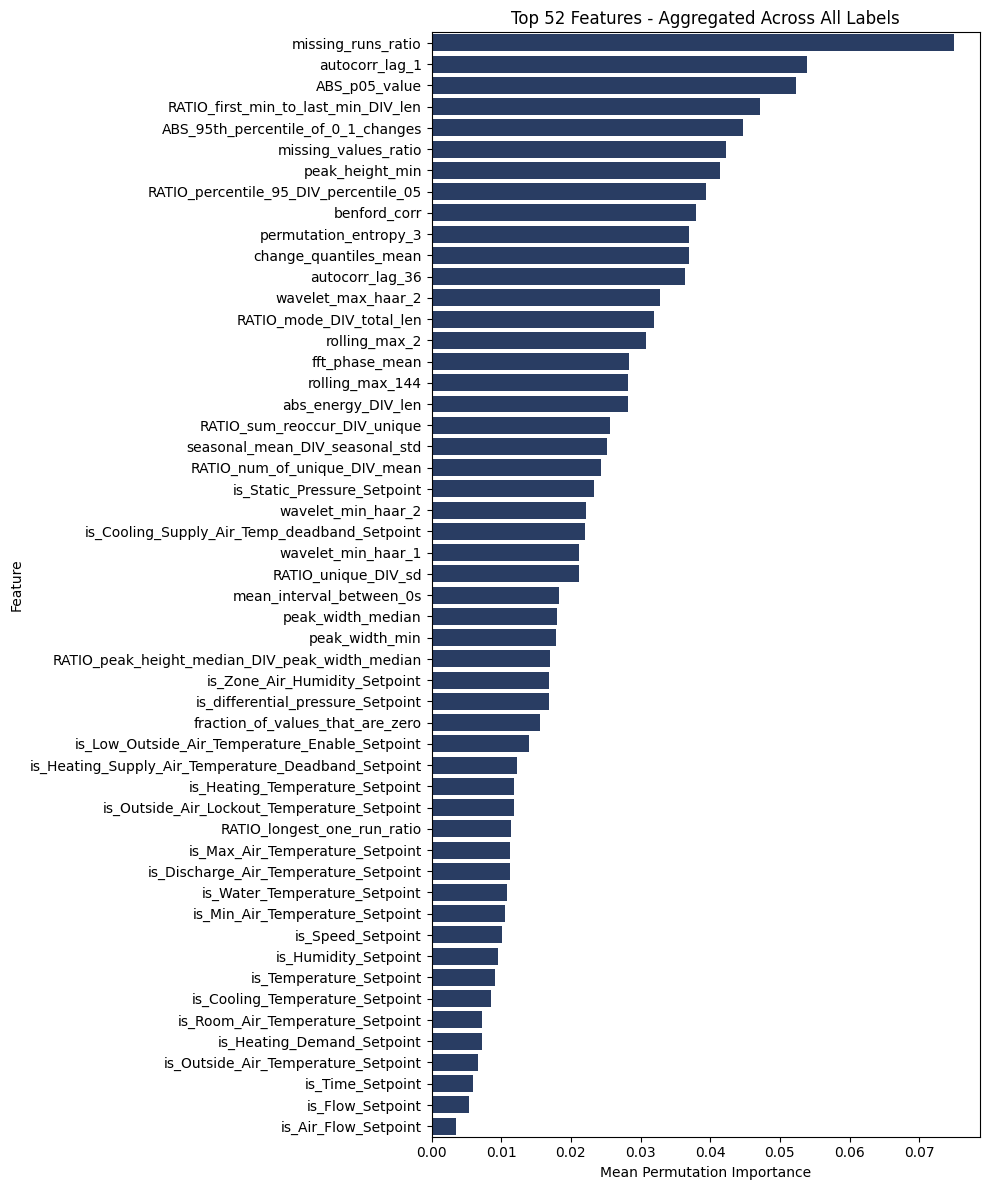

In [ ]:
# 3) Select top N features to plot
top_n = X_train.shape[1]
df_agg_top = df_agg.head(top_n)

# 4) Create a bar plot
plt.figure(figsize=(10, 12))
sns.barplot(
    data=df_agg_top,
    x="importances_mean",
    y="feature",
    color= '#1F3A6D'
)
plt.title(f"Top {top_n} Features - Aggregated Across All Labels")
plt.xlabel("Mean Permutation Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
pd.options.display.max_rows = None
df_agg_top

,feature,importances_mean
40,missing_runs_ratio,0.074983
11,autocorr_lag_1,0.053953
1,ABS_p05_value,0.052342
2,RATIO_first_min_to_last_min_DIV_len,0.047148
0,ABS_95th_percentile_of_0_1_changes,0.044706
41,missing_values_ratio,0.042287
42,peak_height_min,0.041354
7,RATIO_percentile_95_DIV_percentile_05,0.039400
13,benford_corr,0.037918
45,permutation_entropy_3,0.037014
